In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


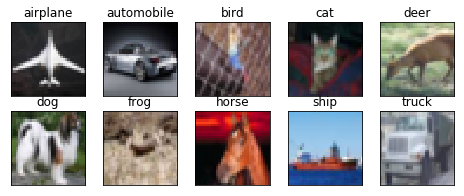

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Cut-out image augmentation
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def _get_smallest_shape(layers):
  return min([layer.get_shape().as_list()[1] for layer in layers])

def _get_smallest_channels(layers):
  return min([layer.get_shape().as_list()[-1] for layer in layers])
      
def _resize_layers(layers, smallest_shape):
  res_layers = []
  for layer in layers:
    layer_shape = layer.get_shape().as_list()[1]
    if layer_shape != smallest_shape:
      ps = layer_shape // smallest_shape
      res_layer = AveragePooling2D(pool_size=(ps, ps))(layer)
      res_layers.append(res_layer)
    else:
      res_layers.append(layer)
  
  return res_layers

def _reduce_channels(conc, smallest_channels):
  return Convolution2D(smallest_channels, (1, 1), padding='same', use_bias=False, activation='relu')(conc)

def merge_layers(layers):
  smallest_shape = _get_smallest_shape(layers)
  smallest_channels = _get_smallest_channels(layers)
  
  resized_layers = _resize_layers(layers, smallest_shape)
  conc = concatenate(resized_layers)
  reduced = _reduce_channels(conc, smallest_channels)
  return reduced


In [9]:
# Define the model

from keras.layers import Input, AveragePooling2D
from keras.models import Model
from keras.layers.merge import add, concatenate

inp = Input(shape=(32,32,3), name='input')

sep1_r = SeparableConv2D(64, (5, 5), use_bias=False, name='sep1', padding='same', activation='relu')(inp)
sep1 = BatchNormalization()(sep1_r)

conv1_r = Convolution2D(64, (5, 5), use_bias=False, name='conv1', padding='same', activation='relu')(sep1)
conv1 = BatchNormalization()(conv1_r)

conv2_r = Convolution2D(64, (5, 5), use_bias=False, name='conv2', padding='same', activation='relu')(conv1)
conv2 = BatchNormalization()(conv2_r)

concat1_r = merge_layers([sep1, conv2])
concat1 = BatchNormalization()(concat1_r)

sep2_r = SeparableConv2D(64, (5, 5), use_bias=False, name='sep2', padding='same', activation='relu')(concat1)
sep2 = BatchNormalization()(sep2_r)

concat2_r = merge_layers([sep1, sep2])
concat2 = BatchNormalization()(concat2_r)
pool1 = MaxPooling2D(2, 2, name='pool1')(concat2)

sep3_r = SeparableConv2D(128, (3, 3), use_bias=False, name='sep3', padding='same', activation='relu')(pool1)
sep3 = BatchNormalization()(sep3_r)

concat4_r = merge_layers([sep2, sep3])
concat4 = BatchNormalization()(concat4_r)

conv3_r = Convolution2D(128, (5, 5), use_bias=False, name='conv3', padding='same', activation='relu')(concat4)
conv3 = BatchNormalization()(conv3_r)

concat5_r = merge_layers([conv2, sep2, sep3, conv3])
concat5 = BatchNormalization()(concat5_r)

sep4_r = SeparableConv2D(128, (3, 3), use_bias=False, name='sep4', padding='same', activation='relu')(concat5)
sep4 = BatchNormalization()(sep4_r)

concat6_r = merge_layers([conv2, conv3, sep1, sep2, sep3, sep4])
concat6 = BatchNormalization()(concat6_r)

sep5_r = SeparableConv2D(128, (5, 5), use_bias=False, name='sep5', padding='same', activation='relu')(concat6)
sep5 = BatchNormalization()(sep5_r)

concat7_r = merge_layers([sep1, sep2, sep3, sep4, sep5])
concat7 = BatchNormalization()(concat7_r)
pool2 = MaxPooling2D(2, 2, name='pool2')(concat7)

concat8_r = merge_layers([conv3, pool2])
concat8 = BatchNormalization()(concat8_r)

conv4_r = Convolution2D(256, (5, 5), use_bias=False, name='conv4', padding='same', activation='relu')(concat8)
conv4 = BatchNormalization()(conv4_r)

concat9_r = merge_layers([sep2, sep4, conv2, conv4])
concat9 = BatchNormalization()(concat9_r)

sep6_r = SeparableConv2D(256, (5, 5), use_bias=False, name='sep6', padding='same', activation='relu')(concat9)
sep6 = BatchNormalization()(sep6_r)

concat10_r = merge_layers([sep3, conv1, conv2, conv4, sep6])
concat10 = BatchNormalization()(concat10_r)

conv5_r = Convolution2D(256, (3, 3), use_bias=False, name='conv5', padding='same', activation='relu')(concat10)
conv5 = BatchNormalization()(conv5_r)

concat11_r = merge_layers([conv2, sep1, sep2, sep3, sep4, sep6, conv5])
concat11 = BatchNormalization()(concat11_r)

sep7_r = SeparableConv2D(256, (5, 5), use_bias=False, name='sep7', padding='same', activation='relu')(concat11)
sep7 = BatchNormalization()(sep7_r)

concat12_r = merge_layers([sep4, sep2, sep6, sep7])
concat12 = BatchNormalization()(concat12_r)

convf = Convolution2D(num_classes, (1, 1), activation='softmax', use_bias=False)(concat12)
gap = GlobalAveragePooling2D()(convf)

model = Model(inputs=[inp], outputs=[gap])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
sep1 (SeparableConv2D)          (None, 32, 32, 64)   267         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         sep1[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   102400      batch_normalization_1[0][0]      
_____________________________________

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
390/390 [==============================] - 59s 152ms/step - loss: 1.5118 - acc: 0.4512 - val_loss: 1.9626 - val_acc: 0.4410

Epoch 00001: val_acc improved from -inf to 0.44100, saving model to model.hdf5
Epoch 2/100
390/390 [==============================] - 52s 134ms/step - loss: 1.1209 - acc: 0.6048 - val_loss: 1.1153 - val_acc: 0.6217

Epoch 00002: val_acc improved from 0.44100 to 0.62170, saving model to model.hdf5
Epoch 3/100
390/390 [==============================] - 51s 131ms/step - loss: 0.9417 - acc: 0.6753 - val_loss: 0.8533 - val_acc: 0.7072

Epoch 00003: val_acc improved from 0.62170 to 0.70720, saving model to model.hdf5
Epoch 4/100
390/390 [==============================] - 51s 132ms/step - loss: 0.8232 - acc: 0.7154 - val_loss: 0.7177 - val_acc: 0.7609

Epoch 00004: val_acc improved from 0.70720 to 0.76090, saving model to model.hdf5
Epoch 5/100
390/390 [============================

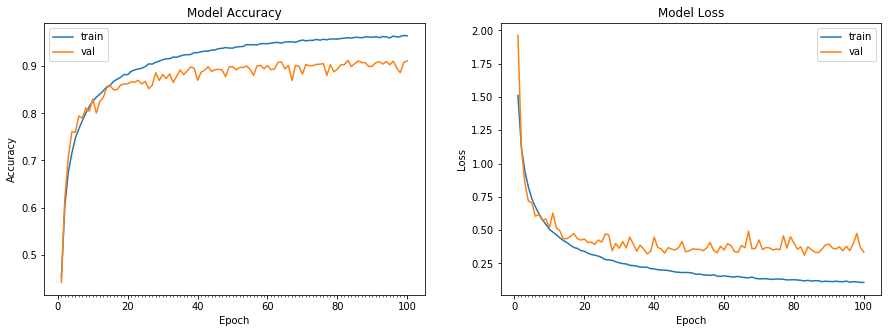

Accuracy on test data is: 91.15


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_features)

filepath = 'model.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100,
                                 callbacks=[model_checkpoint],
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))